# O que é a Lei Rouanet

A Lei Rouanet, oficialmente denominada Lei 8.313/91, é o principal mecanismo de fomento à cultura no Brasil, instituindo o Programa Nacional de Apoio à Cultura (Pronac). Seu nome é uma homenagem ao seu idealizador, o diplomata Sérgio Paulo Rouanet, então secretário Nacional de Cultura. Essa legislação estabelece as diretrizes para o Governo Federal disponibilizar recursos destinados à realização de projetos artístico-culturais. Originalmente, a Lei Rouanet foi concebida com três mecanismos: o Fundo Nacional da Cultura (FNC), o Incentivo Fiscal e o Fundo de Investimento Cultural e Artístico (Ficart). No entanto, o Ficart nunca foi implementado, enquanto o Incentivo Fiscal, também conhecido como mecenato, se destacou e, muitas vezes, é erroneamente associado como sendo a própria Lei Rouanet.

###

# Sobre o projeto

Este projeto oferece a oportunidade de compreender melhor a distribuição de recursos culturais por meio da Lei Rouanet e extrair insights significativos sobre a diversidade e impacto dos projetos financiados. 

**Objetivo do projeto**

Realizar uma análise exploratória de dados (EDA) no conjunto de dados da Lei Rouanet (2009-2024), buscando compreender padrões, tendências e insights relacionados aos projetos culturais financiados por meio dessa lei de incentivo à cultura no Brasil.

## Passos do projeto

### 1. Coletar e Carregar os Dados

- Obter o dataset da Lei Rouanet, disponibilizado pelo Ministério da Cultura [(SALIC)](https://api.salic.cultura.gov.br/doc/)
- Carregar os dados em um DataFrame do pandas.

### 2. Realizar uma Exploração Inicial

- Fazer uma exploração inicial para entender a estrutura do dataset, tipos de variáveis e dados disponíveis.

### 3. Limpar e preparar os dados

- Tratar valores ausentes, inconsistências ou duplicatas.
- Analisar, criar e ajustar categorias relevantes.

### 4. Analisar

**4.1. Segmentação por áreas culturais**

- Classificar os projetos por categorias culturais (música, artes cênicas, audiovisual, etc.).
- Verificar a distribuição das áreas ao longo dos anos
- Analisar a distribuição de recursos por essas diferentes áreas.

**4.2. Participação geográfica**

- Visualizar a participação geográfica dos projetos. Qual região do Brasil recebeu mais incentivos culturais?

**4.3. Analisar a distribuição de recursos**

- Explorar os mecanismos de incentivo à cultura.
- Analisar a dificuldade na captação de recursos.
- Explorar os cálculos de isenção fiscal
- Identificar os projetos que receberam a maior e menor quantidade de financiamento.
- Explorar a distribuição de recursos financeiros ao longo do tempo.

**4.4. Evolução ao longo dos anos**

- Criar gráficos de linha ou de área para mostrar a evolução do número de projetos financiados e do montante investido ao longo dos anos.

**4.5. Influência de grandes projetos**

- Identificar e analisar grandes projetos que receberam um montante significativo de financiamento. Como esses projetos influenciam a distribuição geral?

<!-- **4.5. Análise de contrapartidas**

- Explorar as contrapartidas oferecidas pelos proponentes dos projetos. Quais tipos de contrapartidas são mais comuns? -->

<!-- **4.6. Análise de sucesso**

- Definir critérios para o sucesso de um projeto (por exemplo, avaliação do público, impacto cultural) e explorar quais características estão associadas a projetos bem-sucedidos. -->

### 5. Concluir

- Resumir as principais descobertas do projeto.
- Identificar padrões interessantes, tendências ao longo do tempo e qualquer insight que possa ser valioso para as partes interessadas e tomadores de decisão.

## Ferramentas utilizadas

- Python (`pandas`, `numpy`, `geobr`, `matplotlib` e `seaborn`)
- Jupyter Notebook para documentação e visualização interativa.

###

# Análise de Dados Exploratória

<!-- Fontes:
- https://www.linkedin.com/pulse/entenda-o-que-%C3%A9-lei-rouanet-ficarte-fnc-e-oque-fiscal-oliveira/?originalSubdomain=pt
- https://www.gov.br/cultura/pt-br/centrais-de-conteudo/marcas-e-logotipos/copy_of_ManualdoProponenteMduloIApresentaodePropostas1.pdf
- https://portaldoincentivo.com.br/visitors/incentive_laws/1 -->

### 1. Coletar e Carregar os Dados

**Obter o dataset da Lei Rouanet, disponibilizado pelo Ministério da Cultura [(SALIC)](https://api.salic.cultura.gov.br/doc/)**

Eu desenvolvi um script utilizando as bibliotecas `os`, `request`, `json` e `pandas` para extrair os dados da API referentes aos projetos, propostas, proponentes, incentivadores e fornecedores. Os dados foram salvos em arquivos no formato `xsls`. Devido ao seu tamanho, não foi possível hospedá-los neste repositório. Em vez disso, eu os incluí em uma pasta no Google Drive e compartilhei os links em um arquivo `csv`. 

Esses arquivos podem ser baixados manualmente ou usando um script que criei com as bibliotecas `os` e `gdown`. 

**Carregar os dados em um DataFrame do pandas.**

In [1]:
from os import path

import numpy as np
import pandas as pd

import geobr
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
projetos = pd.read_excel(path.abspath("datasets/projetos.xlsx"))
propostas = pd.read_excel(path.abspath("datasets/propostas.xlsx"))
proponentes = pd.read_excel(path.abspath("datasets/proponentes.xlsx"))
incentivadores = pd.read_excel(path.abspath("datasets/incentivadores.xlsx"))
fornecedores = pd.read_excel(path.abspath("datasets/fornecedores.xlsx"))

####

### 2. Realizar uma Exploração Inicial

**Fazer uma exploração inicial para entender a estrutura do dataset, tipos de variáveis e dados disponíveis.**

In [3]:
projetos.columns

Index(['etapa', 'providencia', 'area', 'enquadramento', 'objetivos',
       'ficha_tecnica', 'situacao', 'outras_fontes', 'acessibilidade',
       'sinopse', 'nome', 'cgccpf', 'mecanismo', '_links', 'segmento',
       'PRONAC', 'estrategia_execucao', 'valor_aprovado', 'justificativa',
       'resumo', 'valor_solicitado', 'especificacao_tecnica', 'municipio',
       'data_termino', 'UF', 'impacto_ambiental', 'democratizacao',
       'valor_projeto', 'proponente', 'ano_projeto', 'data_inicio',
       'valor_captado', 'valor_proposta'],
      dtype='object')

Colunas interessantes para a análise dos **projetos**: 

- `providencia` `situacao`
- `area` `segmento`
- `mecanismo` `enquadramento`
- `valor_aprovado` `valor_projeto` `valor_captado` `valor_proposta`
- `UF` `municipio`
- `ano_projeto` `data_termino` `data_inicio`
- `impacto_ambiental`
- `proponente`
- `_links`

In [4]:
propostas.columns

Index(['data_arquivamento', 'acessibilidade', 'impacto_ambiental', 'nome',
       'democratizacao', 'justificativa', 'mecanismo', 'resumo', 'sinopse',
       'especificacao_tecnica', '_links', 'data_inicio', 'objetivos',
       'ficha_tecnica', 'etapa', 'data_aceite', 'id', 'estrategia_execucao',
       'data_termino'],
      dtype='object')

Colunas interessantes para a análise das **propostas**: 

- `data_arquivamento` `data_aceite` `data_termino`
- `mecanismo`

In [5]:
proponentes.columns

Index(['nome', 'cgccpf', '_links', 'tipo_pessoa', 'responsavel', 'UF',
       'total_captado', 'municipio'],
      dtype='object')

Colunas interessantes para a análise dos **proponentes**: 

- `tipo_pessoa`
- `responsavel`
- `UF` `municipio`
- `total_captado`

In [6]:
incentivadores.columns

Index(['nome', 'cgccpf', 'total_doado', '_links', 'tipo_pessoa', 'responsavel',
       'UF', 'municipio'],
      dtype='object')

Colunas interessantes para a análise dos **incentivadores**: 

- `nome` `tipo_pessoa` `responsavel`
- `total_doado`
- `UF` `municipio`
- `_links`

In [7]:
fornecedores.columns

Index(['cgccpf', '_links', 'email', 'nome'], dtype='object')

Colunas interessantes para a análise dos **incentivadores**: 

- `nome`
- `_links`

####

### 3. Limpar e preparar os dados

**Tratar valores ausentes, inconsistências ou duplicatas.**

Reduzindo os dfs para conter apenas as informações necessárias:

In [8]:
projetos = projetos[["providencia", "situacao", "area", "segmento", "mecanismo", "enquadramento",
                     "valor_aprovado", "valor_projeto", "valor_captado", "valor_proposta",
                     "UF", "municipio", "ano_projeto", "data_termino", "data_inicio",
                     "impacto_ambiental", "proponente", "_links"]].sort_values("ano_projeto")

propostas = propostas[["data_arquivamento", "data_aceite", "data_termino", "mecanismo"]].sort_values(by="data_aceite")

proponentes = proponentes[["tipo_pessoa", "responsavel", "UF", "municipio", "total_captado"]].sort_values("total_captado", ascending=False)

incentivadores = incentivadores[["nome", "tipo_pessoa", "responsavel", "total_doado", "UF", "municipio", "_links"]]

fornecedores = fornecedores[["nome", "_links"]]

In [9]:
# removendo anomalias
projetos = projetos[projetos["valor_projeto"] >= 0]
projetos = projetos[projetos["valor_aprovado"] >= 0]
projetos = projetos[~((projetos["mecanismo"] == "FNC") & (projetos["area"] == "Audiovisual"))] 

Tratamento dos dados das propostas:

In [10]:
propostas = propostas[propostas[["data_arquivamento", "data_aceite", "data_termino"]].any(axis=1)]

Tratamento dos dados dos proponentes:

In [11]:
uf_invalidos = ["  ", "35", "33", "41", "51", "15", "26", "53"]
proponentes = proponentes[~(proponentes["UF"].str.contains("|".join(uf_invalidos))) & ~(proponentes["responsavel"] == '.')]

Tratamento dos dados dos incentivadores:

In [12]:
uf_invalidos = ["  ", "13", "15", "17", "21", "22", "23", "25", "26", "27", "28", "29", "31", "32", "33", "35", "41", "42", "43", "50", "51", "52", "53", "NI"]
incentivadores = incentivadores[~incentivadores["UF"].str.contains("|".join(uf_invalidos))]

Os dados dos fornecedores não requerem tratamento.

#####

**Analisar, criar e ajustar categorias relevantes.**

Dividir estados por regiões do Brasil:

In [13]:
def regiao_do_uf(uf):
    regioes = {
        "Centro Oeste": ["DF", "GO", "MS", "MT"],
        "Nordeste": ["AL", "BA", "CE", "MA", "PB", "PE", "PI", "RN", "SE"],
        "Norte": ["AC", "AM", "AP", "PA", "RO", "RR", "TO"],
        "Sudeste": ["ES", "MG", "RJ", "SP"],
        "Sul": ["PR", "RS", "SC"]
    }
    for regiao, estados in regioes.items():
        if uf in estados:
            return regiao

regioes = pd.Series(projetos["UF"].apply(regiao_do_uf), name="regioes")

if "regioes" not in projetos.columns:
    projetos = pd.concat([projetos, regioes], axis=1)

####

### 4. Analisar

#### 4.1. Segmentação por áreas culturais

**Classificar os projetos por categorias culturais (música, artes cênicas, audiovisual, etc.).**

Inicialmente, realizei as contagens dos projetos segmentados por áreas.

In [14]:
areas_por_regioes = projetos.groupby("regioes")["area"].value_counts(normalize=True, sort=False) * 100
medias = np.average(np.array(areas_por_regioes).reshape(5, -1), axis=0) # 5 regiões do Brasil
rotulos = areas_por_regioes['Norte'].index
areas_por_regioes = pd.Series(medias, index=rotulos, name="frequencia_relativa").sort_values(ascending=False)

areas = projetos["area"].value_counts(normalize=True) * 100

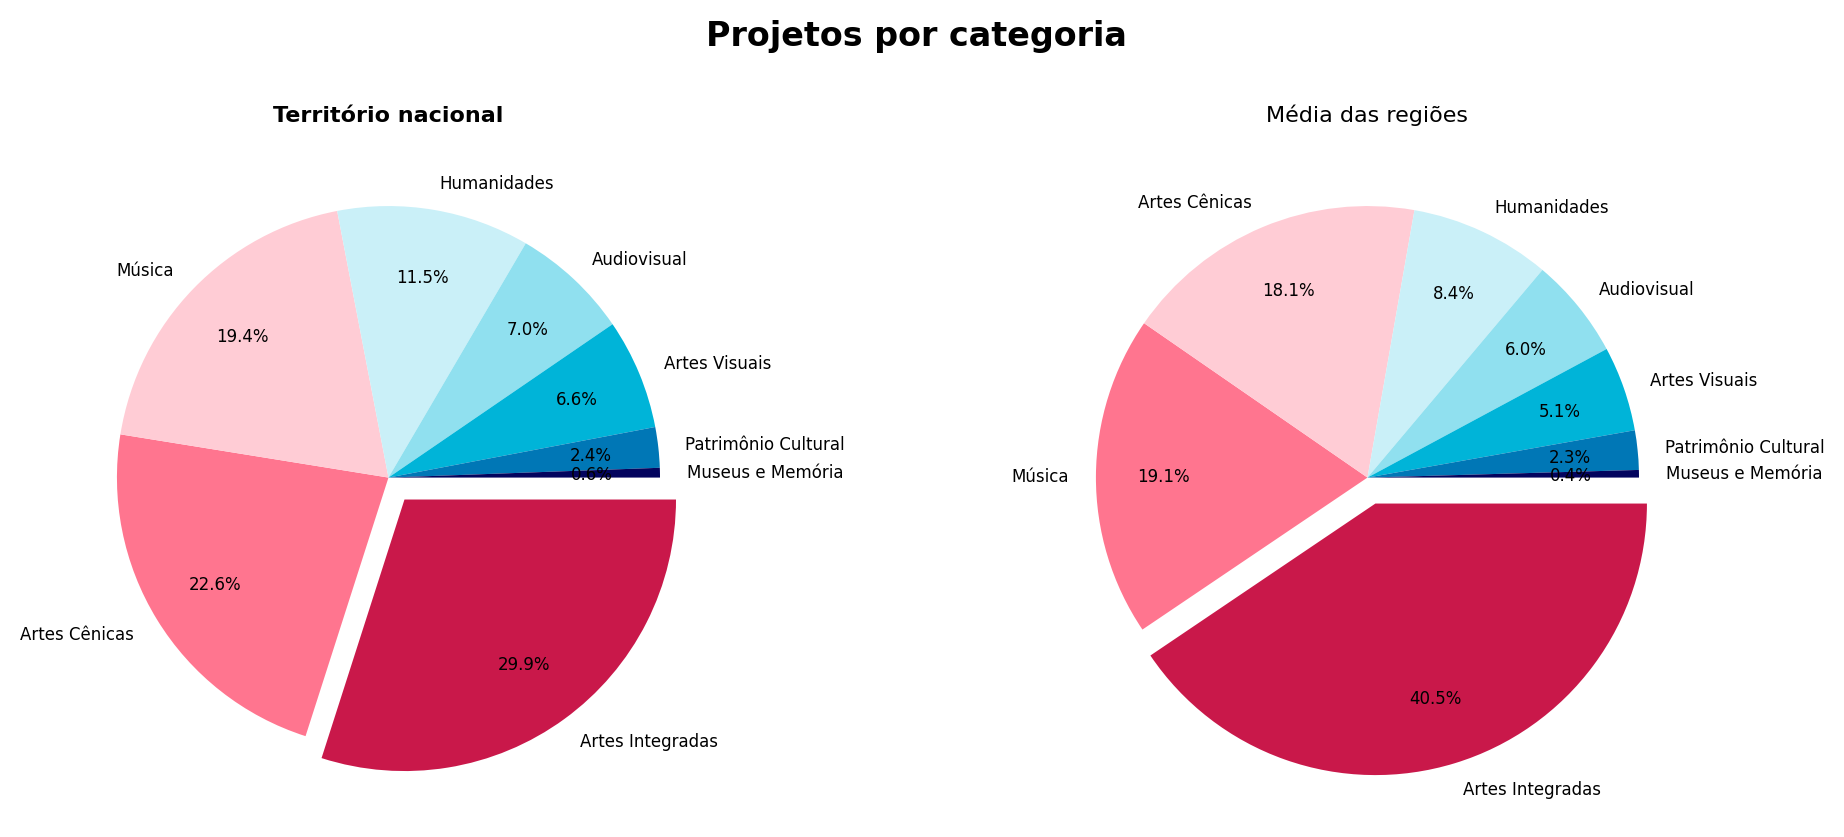

In [123]:
plt.rcParams.update({"font.size": 6})
cores = ["#c9184a", "#ff758f", "#ffccd5", "#caf0f8", 
          "#90e0ef", "#00b4d8", "#0077b6", "#03045e"]
separacao_fatia = (0.1, 0, 0, 0, 0, 0, 0, 0)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), dpi=200)

ax1.pie(
    areas, 
    labels=areas.index, 
    autopct='%1.1f%%', 
    pctdistance=0.75,
    counterclock=False,
    colors=cores, 
    explode=separacao_fatia
)

ax2.pie(
    areas_por_regioes, 
    labels=areas_por_regioes.index, 
    autopct='%1.1f%%', 
    pctdistance=0.75,
    counterclock=False,
    colors=cores, 
    explode=separacao_fatia
)

fig.suptitle('Projetos por categoria', fontsize=12, fontweight=1000, y=1.02)
ax1.set_title('Território nacional', fontsize=8, fontweight=600)
ax2.set_title('Média das regiões', fontsize=8)

plt.tight_layout()
plt.show()

Logo em seguida comecei a analisar os segmentos.

Os 10 segmentos com maior frequência absoluta representam aproximadamente 75% do total de projetos, sendo a Cultura Popular o mais significativo (27,7%). A Cultura Popular é um segmento de Artes Integradas.

In [16]:
segmentos_por_area = projetos.groupby("area")["segmento"].value_counts()

In [17]:
projetos["segmento"].value_counts()[:10] / projetos.shape[0] * 100

segmento
Cultura Popular                                       27.751429
Apresentação ou Performance de Teatro                 14.837688
Apresentação/Gravação de Música Instrumental           7.204746
Apresentação/Gravação Música Popular Cantada Art26     6.724597
Exposição de Artes Visuais                             3.976101
Apresentação ou Performance de Dança                   3.834487
Apresentação/Gravação de Música Erudita                3.013290
Livros ou  obras de referência - valor Humanístico     2.564146
Artes Integradas                                       2.414989
Livros  ou obras de referência - valor Artístico       2.204662
Name: count, dtype: float64

Outro dado interessante é sobre os projetos voltados para as minorias. De acordo com os segmentos, apenas 0.08% dos projetos são voltados especificamente para as minorias sociais do Brasil.

In [18]:
minorias = ["afro", "indígena", "baixa renda", "mulher", "pcd", "lgbt", "idoso"]
projetos[projetos["segmento"].str.lower().str.contains("|".join(minorias))].index.size / projetos.shape[0] * 100

0.08379560575843402

#####

**Verificar a distribuição das áreas ao longo dos anos.**

#####

**Analisar a distribuição de recursos por essas diferentes áreas.**

In [19]:
# areas mais lucrativas (maior valor captado - média por projeto)
# areas mais caras (maior valor aprovado - média por projeto)
# areas dos 10 projetos mais caros
# areas dos 10 projetos mais baratos
# relacao entre valor aprovado e valor captado: quanto mais caro o projeto, mais dificil de captar os recursos?

####

#### 4.2. Participação geográfica

**Visualizar a participação geográfica dos projetos.**

Inicialmente, realizei a contagem de projetos por regiões e por estados e plotei os resultados em um gráfico.

In [38]:
warnings.filterwarnings("ignore")

projetos_por_regiao = projetos["regioes"].value_counts().rename("qtd_projetos")
regioes = geobr.read_region() # Download do mapa do Brasil dividido por regiões
regioes = regioes.merge(projetos_por_regiao, how="left", left_on="name_region", right_on="regioes")

projetos_por_estados = projetos["UF"].value_counts().rename("qtd_projetos")
estados = geobr.read_country(year=2020)  # Download do mapa do Brasil dividido por estados
estados = estados.merge(projetos_por_estados, how="left", left_on="abbrev_state", right_on="UF")

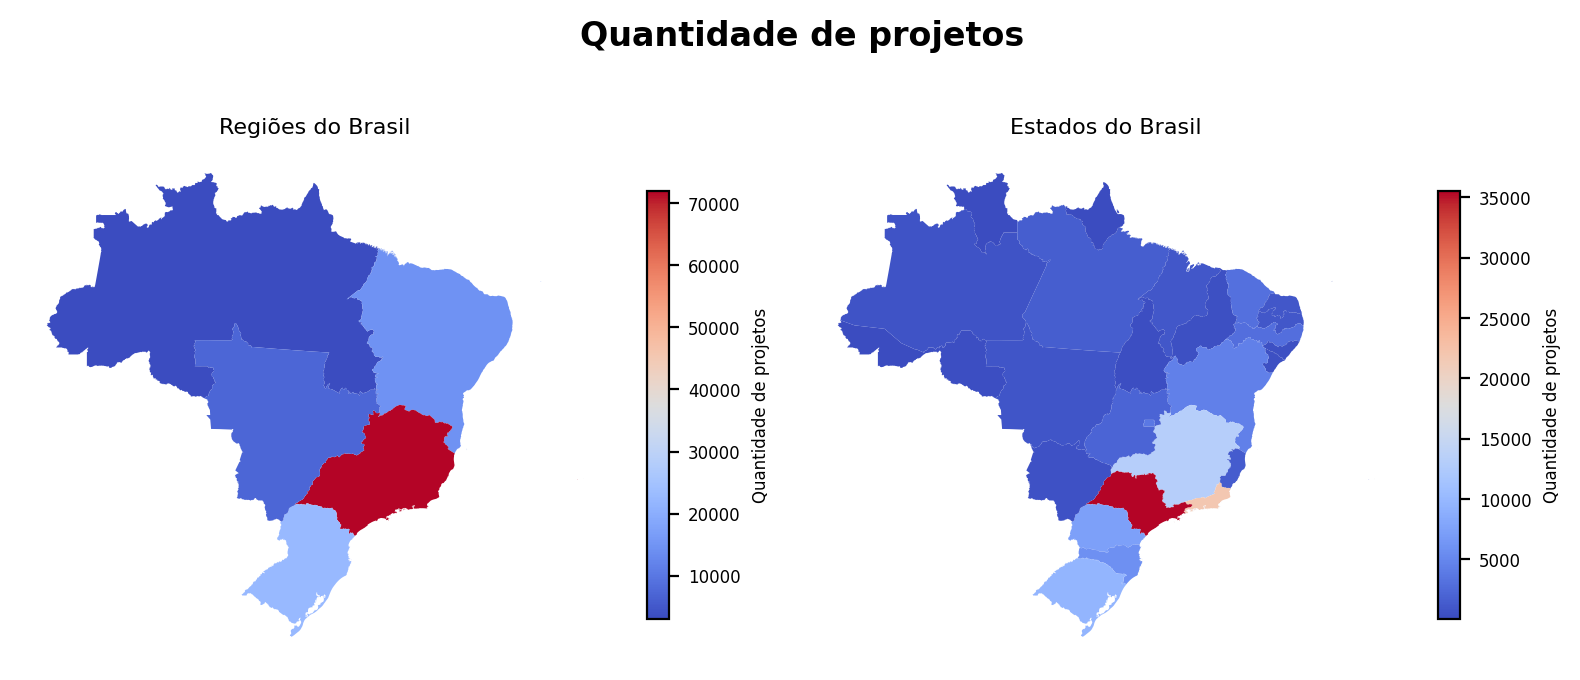

In [124]:
plt.rcParams.update({"font.size": 6})

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), dpi=200)

regioes.plot(
    column="qtd_projetos",
    cmap="coolwarm",
    legend=True,
    legend_kwds={
        "label": "Quantidade de projetos",
        "orientation": "vertical",
        "shrink": 0.6,
    },
    ax=axs[0],
)

estados.plot(
    column="qtd_projetos",
    cmap="coolwarm",
    legend=True,
    legend_kwds={
        "label": "Quantidade de projetos",
        "orientation": "vertical",
        "shrink": 0.6,
    },
    ax=axs[1],
)

fig.suptitle('Quantidade de projetos', fontsize=12, fontweight=1000, y=0.95)
axs[0].set_title("Regiões do Brasil", fontsize=8)
axs[1].set_title("Estados do Brasil", fontsize=8)

axs[0].axis("off")
axs[1].axis("off")

plt.tight_layout()
plt.show()

In [22]:
warnings.filterwarnings("default")

####

#### 4.3. Analisar a distribuição de recursos

**Explorar os mecanismos de incentivo à cultura.**

Sobre os mecanismos utilizados pela Lei Rouanet:

- Incentivo Fiscal (mecenato)

O incentivo é um mecanismo em que a União faculta às pessoas físicas ou jurídicas a opção pela aplicação de parcelas do Imposto sobre a Renda, a título de doações ou patrocínios, no apoio direto a projetos culturais aprovados pelo Ministério da Cultura. Ou seja: o Governo Federal oferece uma ferramenta para que a sociedade possa decidir aplicar parte do dinheiro de seus impostos em ações culturais. Desta maneira, o incentivo fiscal estimula a participação da iniciativa privada, do mercado empresarial e dos cidadãos no aporte de recursos para o campo da cultura, diversificando possibilidades de financiamento, ampliando o volume de recursos destinados ao setor, atribuindo a ele mais potência e mais estratégia econômica.

- Fundo Nacional da Cultura (FNC)

O Fundo Nacional da Cultura (FNC) representa o investimento direto do Estado no fomento à Cultura, já que o apoio a projetos decorre de recursos do orçamento da União dentre outras fontes, como 3% do valor bruto arrecado pelas loterias federais e doações. O apoio via FNC tem como objetivo promover a distribuição regional dos recursos de forma equilibrada e é voltado aos projetos com maior dificuldade de captação junto ao mercado.

In [90]:
mecanismos = projetos["mecanismo"].value_counts(normalize=True) * 100
mecenato_por_anos = projetos[projetos["mecanismo"] == "Mecenato"]["ano_projeto"].value_counts().sort_index()
fnc_por_anos = projetos[projetos["mecanismo"] == "FNC"]["ano_projeto"].value_counts().sort_index()

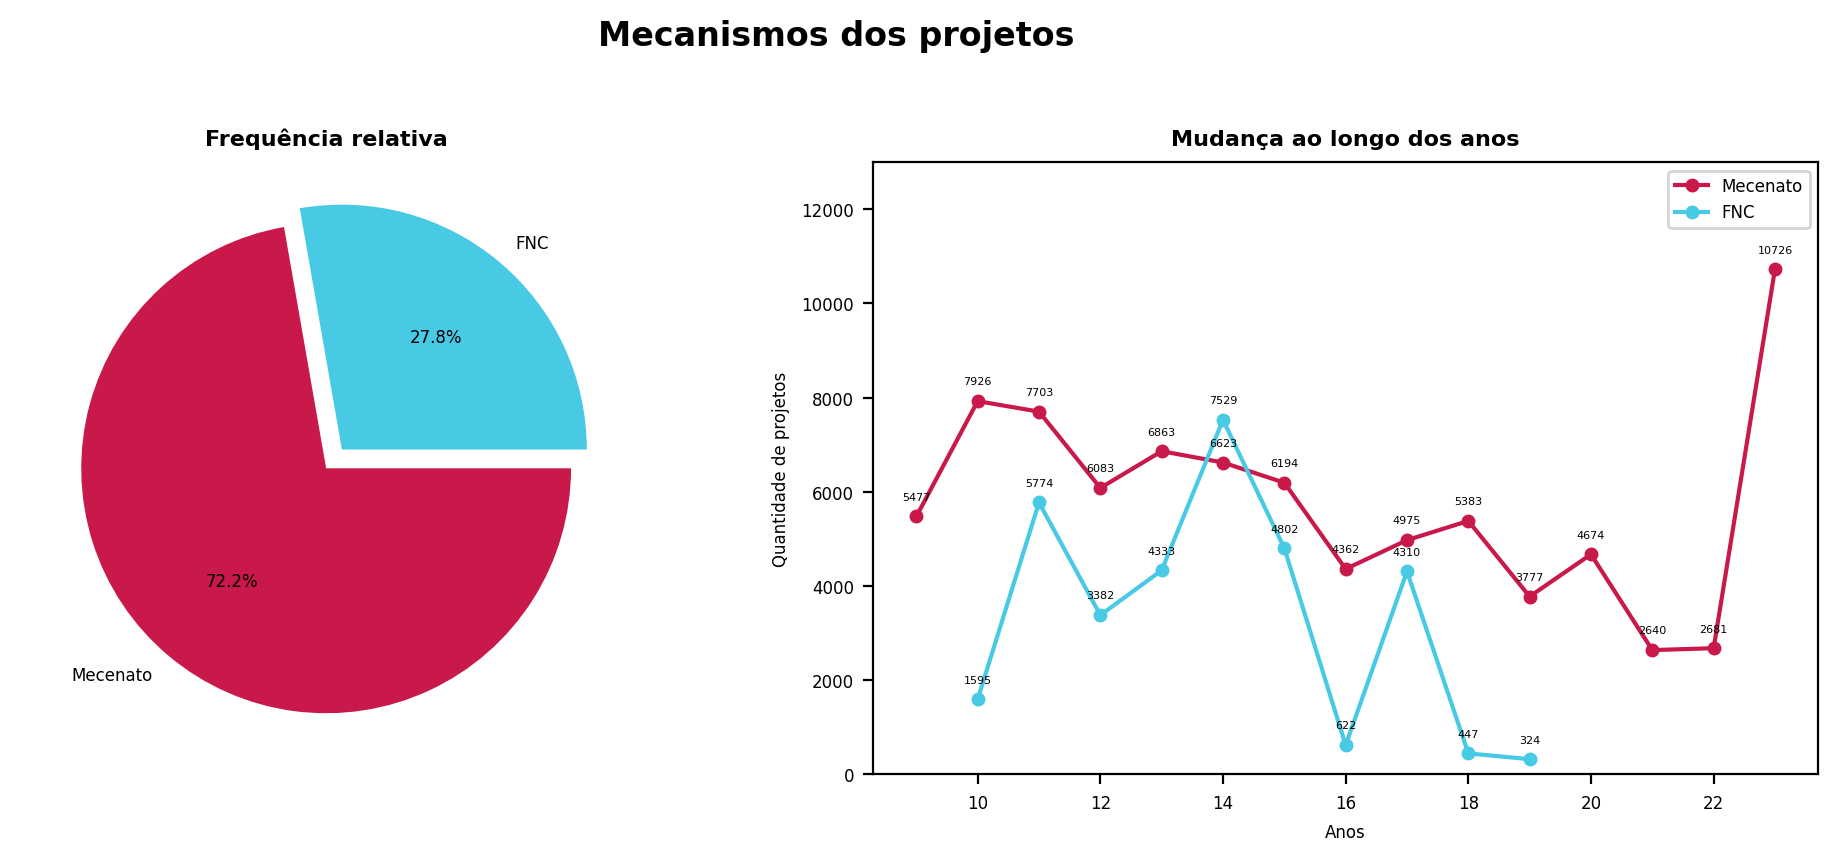

In [188]:
plt.rcParams.update({"font.size": 6})
cores = ["#c9184a", "#48cae4"]
separacao_fatia = (0, 0.1)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), dpi=200)

ax1.pie(
    mecanismos,
    labels=mecanismos.index,
    autopct="%1.1f%%",
    counterclock=False,
    colors=cores,
    explode=separacao_fatia
)

ax2.plot(
    # considerar até 2023, pois 2024 acabou de começar
    mecenato_por_anos.index[:-1], 
    mecenato_por_anos[:-1], 
    cores[0],
    
    fnc_por_anos.index,
    fnc_por_anos,
    cores[1],
    
    marker="o",
    markersize=4
)

for x, y in zip(mecenato_por_anos.index[:-1], mecenato_por_anos[:-1]):
    rotulo = "{}".format(y)
    ax2.annotate(
        rotulo,
        (x, y),
        textcoords="offset points",
        xytext=(0, 6),
        fontsize=4,
        ha='center'
    )

for x, y in zip(fnc_por_anos.index, fnc_por_anos):
    rotulo = "{}".format(y)
    ax2.annotate(
        rotulo,
        xy=(x, y),
        textcoords="offset points",
        xytext=(0, 6),
        fontsize=4,
        ha='center'
    )

plt.suptitle("Mecanismos dos projetos", fontsize=12, fontweight=1000, y=1.05)
ax1.set_title("Frequência relativa", fontsize=8, fontweight=600)
ax2.set_title("Mudança ao longo dos anos", fontsize=8, fontweight=600)

plt.xlabel("Anos")
plt.ylabel("Quantidade de projetos")

ax2.legend(["Mecenato", "FNC"])

plt.ylim(bottom=0, top=13000)

plt.tight_layout()
plt.show()

Ao longo dos anos, a maior fatia dos projetos foi financiada pelo mecenato, sendo que o financiamento pelo estado ocorreu em 27,7% dos projetos.

Curiosamente, as Artes Integradas, área que representa a maior quantidade de projetos no Brasil e suas respectivas regiões, tem a grande maioria de seus projetos financiados pelo Estado. Segundo os dados, além das Artes Integradas, apenas 1 outro projeto foi financiado com o mecanismo do FNC, na área de Audiovisual. O restante dos projetos foram financiados via mecenato. Este projeto de Audiovisual será considerado uma anomalia e descartado para esta análise.

In [25]:
mecenatos_por_area = projetos[projetos["mecanismo"] == "Mecenato"]["area"].value_counts().sort_values(ascending=False)
fnc_por_area = projetos[projetos["mecanismo"] == "FNC"]["area"].value_counts()

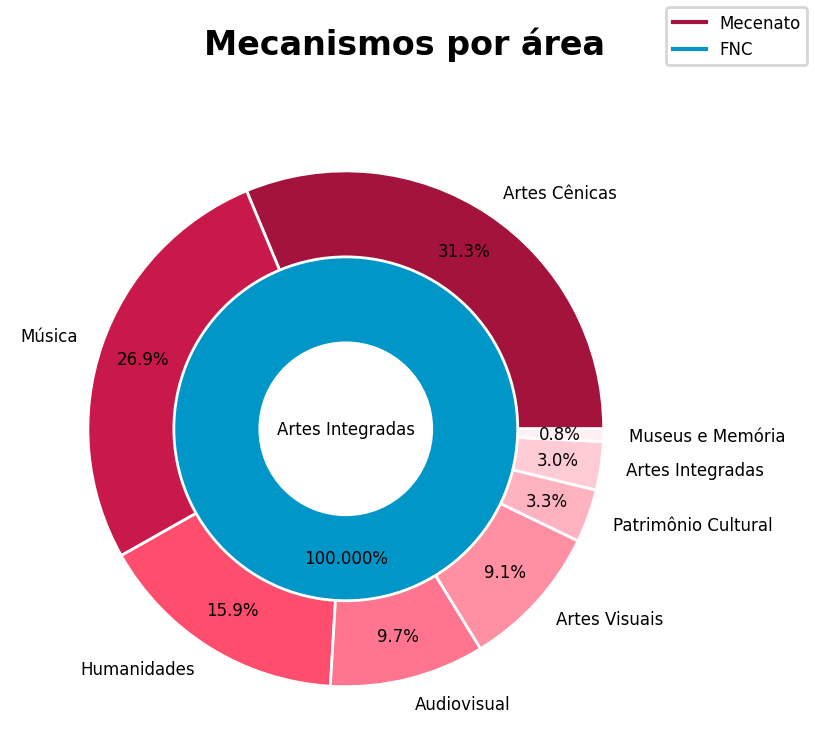

In [177]:
plt.rcParams.update({"font.size": 6})
cores = ["#a4133c", "#c9184a", "#ff4d6d", "#ff758f", 
          "#ff8fa3", "#ffb3c1", "#ffccd5", "#fff0f3"]

fig, ax = plt.subplots(figsize=(4, 4), dpi=200)

ax.pie(
    mecenatos_por_area,
    labels=mecenatos_por_area.index,
    autopct="%1.1f%%",
    pctdistance=0.83,
    radius=1.2, 
    wedgeprops=dict(width=0.5, edgecolor='w'),
    colors=cores
)

ax.pie(
    fnc_por_area,
    labels=fnc_por_area.index,
    labeldistance=0,
    startangle=90,
    autopct="%1.3f%%",
    pctdistance=0.75,
    radius=0.8,
    wedgeprops=dict(width=0.4, edgecolor='w'),
    textprops=dict(ha="center"),
    colors=["#0096c7", "#03045e"]
)

plt.suptitle("Mecanismos por área", fontsize=12, fontweight=1000)

mecenatos, = ax.plot(mecenatos_por_area, label='Mecenato', color=cores[0])
fncs, = ax.plot(fnc_por_area, label='FNC', color="#0096c7")

fig.legend(handles=[mecenatos, fncs], loc="upper right")

plt.tight_layout()
plt.show()

Em relação à divisão regional, percebe-se que os empresários financiam mais projetos no sul e sudeste (de forma expressiva). No Norte, o FNC ultrapassa o Incentivo Fiscal como mecanismo, enquanto no Nordeste e Centro Oeste ambos mecanismos estão em patamares próximos.

In [27]:
mecenato_por_regiao = projetos[projetos["mecanismo"] == "Mecenato"]["regioes"].value_counts().sort_index()
fnc_por_regiao = projetos[projetos["mecanismo"] == "FNC"]["regioes"].value_counts().sort_index()

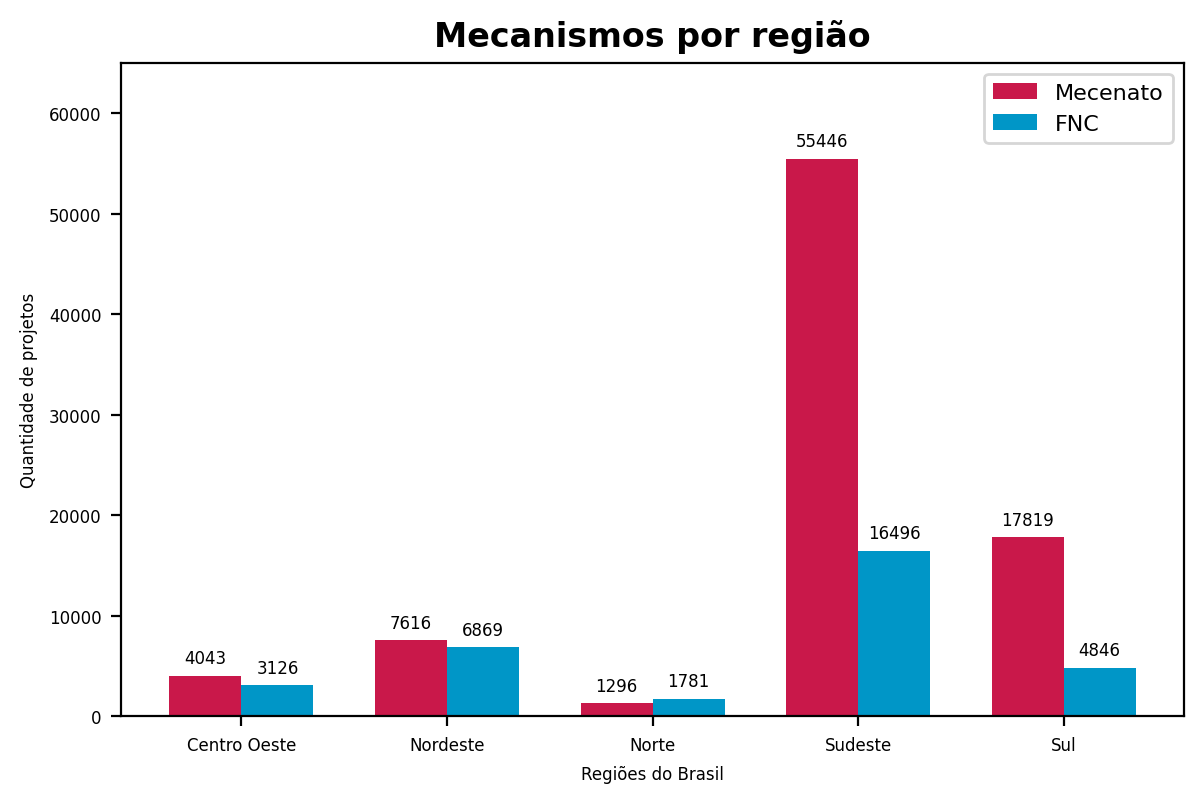

In [187]:
plt.rcParams.update({"font.size": 6})
cores = ["#c9184a", "#0096c7"]

rotulos = mecenato_por_regiao.index
localizacao_rotulos = np.arange(len(rotulos))
largura = 0.35

fig, ax = plt.subplots(figsize=(6, 4), dpi=200)

barras1 = ax.bar(
    localizacao_rotulos - largura / 2, 
    mecenato_por_regiao, 
    width=largura, 
    label="Mecenato", 
    color=cores[0]
)

barras2 = ax.bar(
    localizacao_rotulos + largura / 2, 
    fnc_por_regiao, 
    width=largura, 
    label="FNC", 
    color=cores[1]
)

ax.set_title("Mecanismos por região", fontsize=12, fontweight=1000)

ax.set_xlabel("Regiões do Brasil")
ax.set_ylabel("Quantidade de projetos")

ax.set_xticks(localizacao_rotulos)
ax.set_xticklabels(rotulos)

ax.legend(fontsize=8)


def autolabel(barras):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for barra in barras:
        altura = barra.get_height()
        ax.annotate(
            f'{altura}',
            xy=(barra.get_x() + barra.get_width() / 2, altura),
            xytext=(0, 3),
            textcoords="offset points",
            ha='center',
            va='bottom'
        )


autolabel(barras1)
autolabel(barras2)


plt.ylim(top=65000)

fig.tight_layout()
plt.show();

#####

**Analisar a dificuldade na captação de recursos.**

É preciso considerar que apenas projetos cujo mecanismo é o Mecenato possuem a etapa de captação de recursos na hora de calcular a porcentagem de projetos que tiveram dificuldade em captar recursos em relação ao total de projetos. 

Logo, como a área de Artes Integradas tem a grande maioria de seus projetos financiados pelo Estado, foram considerados no cálculo apenas aqueles cujo mecanismo é o Incentivo Fiscal, vulgo mecenato.

In [240]:
situacao_captacao_projetos = ["Arquivado - por excesso de prazo sem captação", 
                              "Projeto encerrado por excesso de prazo sem captação", 
                              "Arquivado - atingiu 24 meses de aprovação sem captação de recursos", 
                              "Projeto não executado por insuficiência de captação de recursos"]

dificuldade_captacao_recursos = projetos[(projetos["situacao"].str.contains("|".join(situacao_captacao_projetos)))]
projetos_via_mecenato = projetos[projetos["mecanismo"] == "Mecenato"]
dificuldade_captacao_recursos_area = dificuldade_captacao_recursos["area"].value_counts().sort_index() / projetos_via_mecenato["area"].value_counts().sort_index() * 100

percentual_valores_area = dificuldade_captacao_recursos.groupby("area")["valor_aprovado"].sum() / dificuldade_captacao_recursos["valor_aprovado"].sum() * 100

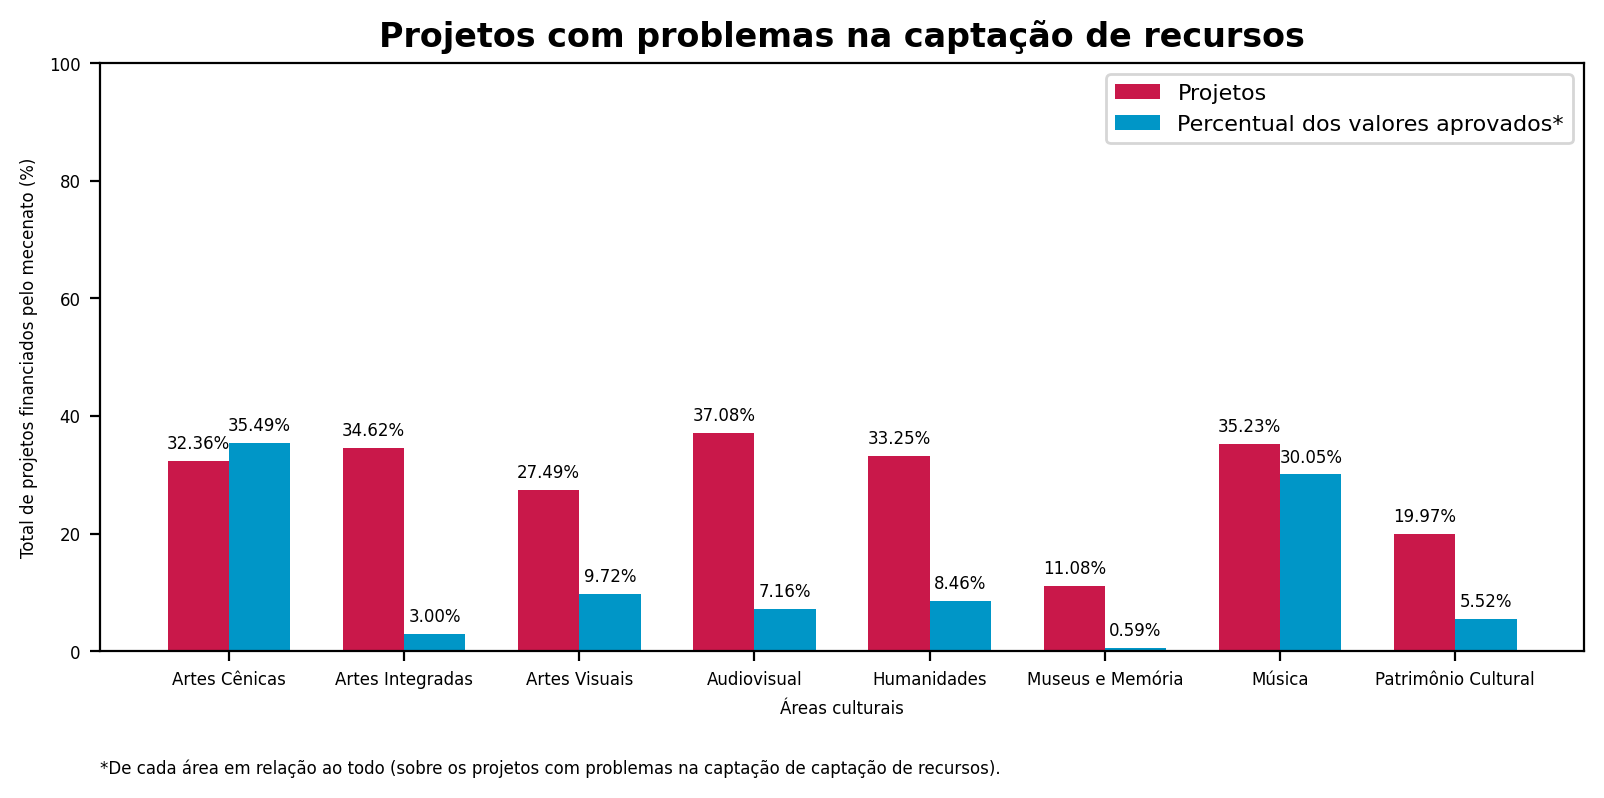

In [237]:
plt.rcParams.update({"font.size": 6})
cores = ["#c9184a", "#0096c7"]

rotulos = percentual_valores_area.index
localizacao_rotulos = np.arange(len(rotulos))
largura = 0.35

fig, ax = plt.subplots(figsize=(8, 4), dpi=200)

barras1 = ax.bar(
    localizacao_rotulos - largura/2, 
    dificuldade_captacao_recursos_area, 
    largura, 
    label="Projetos", 
    color=cores[0]
)

barras2 = ax.bar(
    localizacao_rotulos + largura/2, 
    percentual_valores_area, 
    largura, 
    label="Percentual dos valores aprovados*", 
    color=cores[1]
)

ax.set_title("Projetos com problemas na captação de recursos", fontsize=12, fontweight=1000)

ax.set_xlabel("Áreas culturais")
ax.set_ylabel("Total de projetos financiados pelo mecenato (%)")

ax.set_xticks(localizacao_rotulos)
ax.set_xticklabels(rotulos)

ax.legend(fontsize=8)


def autolabel(barras):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for barra in barras:
        altura = barra.get_height()
        ax.annotate(
            f'{altura:.2f}%',
            xy=(barra.get_x() + barra.get_width() / 2, altura),
            xytext=(0, 3),
            textcoords="offset points",
            ha='center',
            va='bottom'
        )


ax.annotate(
    '*De cada área em relação ao todo (sobre os projetos com problemas na captação de captação de recursos).',
    xy = (0, -0.2),
    xycoords='axes fraction',
    ha='left',
    va="center"
)

autolabel(barras1)
autolabel(barras2)

plt.ylim(top=100)

fig.tight_layout()
plt.show();

#####

**Explorar os cálculos de isenção fiscal**

Projetos aprovados no Artigo 18 da Lei Rouanet podem ser patrocinados com 100% de isenção fiscal, tanto por pessoa jurídica quanto física, enquanto projetos aprovados no Artigo 26 da Lei Rouanet oferecem os seguintes limites de isenção fiscal:

Pessoa Jurídica

- 40% do valor incentivado, no caso de doação.
- 30% do valor incentivado, no caso de patrocínio.

Pessoa Física

- 80% do valor incentivado, no caso de doação.
- 60% do valor incentivado, no caso de patrocínio.

Abeixo está uma relação sobre os projetos enquadrados

In [ ]:
projetos.groupby("mecanismo")["enquadramento"].value_counts()

#####

**Identificar os projetos que receberam a maior e menor quantidade de financiamento.**

#####

**Explorar a distribuição de recursos financeiros ao longo do tempo.**

####

#### 4.4. Evolução ao longo dos anos

**Criar gráficos de linha ou de área para mostrar a evolução do número de projetos financiados e do montante investido ao longo dos anos.**

####

#### 4.5. Influência de grandes projetos

**Identificar e analisar grandes projetos que receberam um montante significativo de financiamento. Como esses projetos influenciam a distribuição geral?**

###

### 5. Concluir

**Resumir as principais descobertas do projeto.**

#####

**Identificar padrões interessantes, tendências ao longo do tempo e qualquer insight que possa ser valioso para as partes interessadas e tomadores de decisão.**